Mounting Google Drive

In [ ]:
from google.colab import auth
auth.authenticate_user()

from googleapiclient.discovery import build
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Installation

In [ ]:
# Install required libraries
!pip install -U tensorflow tensorflow-hub opencv-python scikit-learn

  Using cached tensorflow-2.19.0-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (4.1 kB)
  Using cached tensorboard-2.19.0-py3-none-any.whl.metadata (1.8 kB)


Import Libraries

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import os
import cv2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Masking
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report
from tensorflow.keras.utils import to_categorical

Load MoveNet Thunder

In [ ]:
# Use Lightning (smaller and faster than Thunder, but same structure)
movenet = hub.load("https://tfhub.dev/google/movenet/singlepose/lightning/4")


Pose Estimation Function

In [ ]:
def detect_pose(img):
    input_image = tf.image.resize_with_pad(tf.expand_dims(img, axis=0), 256, 256)
    input_image = tf.cast(input_image, dtype=tf.int32)
    outputs = movenet.signatures['serving_default'](input_image)
    keypoints = outputs['output_0'].numpy()[0, 0, :, :2]  # (17, 2)
    return keypoints.flatten()  # shape: (34,)

Extract Keypoint Sequences from a Folder

In [ ]:
def extract_sequence_from_folder(video_folder, max_frames=30):
    frames = []
    for filename in sorted(os.listdir(video_folder))[:max_frames]:
        if filename.endswith('.jpg') or filename.endswith('.png'):
            img_path = os.path.join(video_folder, filename)
            img = cv2.imread(img_path)
            img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            pose = detect_pose(img_rgb)
            frames.append(pose)
    while len(frames) < max_frames:
        frames.append(np.zeros(34))  # zero padding
    return np.array(frames)

Load All Data, Then Split

In [ ]:
import re
from collections import defaultdict

def extract_video_id(filename):
    # Extracts "Arson_17" or "Normal_07" as ID
    match = re.match(r"([A-Za-z]+_\d+)_frame\d+\.jpg", filename)
    return match.group(1) if match else None

def load_flat_lstm_dataset(base_path, max_frames=30):
    X = []
    y = []

    for label in ['arson', 'normal ']:  # keep space if your folder has one
        folder = os.path.join(base_path, label)
        print(f"\n📂 Loading: {folder}")

        all_files = [f for f in os.listdir(folder) if f.endswith('.jpg')]
        video_groups = defaultdict(list)

        for file in all_files:
            video_id = extract_video_id(file)
            if video_id:
                video_groups[video_id].append(file)

        print(f"🔍 Found {len(video_groups)} videos in '{label}'")

        for video_id, frames in video_groups.items():
            sorted_frames = sorted(frames, key=lambda x: int(re.findall(r'frame(\d+)', x)[0]))
            selected_frames = sorted_frames[:max_frames]
            sequence = []

            for frame_file in selected_frames:
                img_path = os.path.join(folder, frame_file)
                img = cv2.imread(img_path)
                if img is not None:
                    img = cv2.resize(img, (192, 192))
                    img = img.astype('float32') / 255.0
                    sequence.append(img)
                else:
                    print(f"❌ Failed to read {img_path}")

            if len(sequence) == max_frames:
                X.append(np.array(sequence))
                y.append(label.strip())  # strip space from label

    print(f"\n✅ Total samples: {len(X)}")
    print(f"✅ Labels: {set(y)}")
    return np.array(X), np.array(y)


Split into Train and Test

In [ ]:
X_train, y_train = load_flat_lstm_dataset('/content/drive/MyDrive/normalized_dataset/train', max_frames=30)
X_test, y_test = load_flat_lstm_dataset('/content/drive/MyDrive/normalized_dataset/test', max_frames=30)


📂 Loading: /content/drive/MyDrive/normalized_dataset/train/arson
🔍 Found 24 videos in 'arson'

📂 Loading: /content/drive/MyDrive/normalized_dataset/train/normal 
🔍 Found 24 videos in 'normal '

✅ Total samples: 27
✅ Labels: {'normal', 'arson'}

📂 Loading: /content/drive/MyDrive/normalized_dataset/test/arson
🔍 Found 6 videos in 'arson'

📂 Loading: /content/drive/MyDrive/normalized_dataset/test/normal 
🔍 Found 6 videos in 'normal '

✅ Total samples: 8
✅ Labels: {'normal', 'arson'}


Encode Labels

In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_test_enc  = to_categorical(le.transform(y_test))

print("Classes:", le.classes_)
print("Train / Test samples:", len(y_train), len(y_test))

Classes: ['arson' 'normal']
Train / Test samples: 27 8


Build LSTM Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (TimeDistributed, Conv2D, MaxPooling2D,
                                     GlobalAveragePooling2D, LSTM, Dropout, Dense)

model = Sequential([
    TimeDistributed(Conv2D(8, (3, 3), activation='relu'), input_shape=(30, 128, 128, 3)),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(Conv2D(16, (3, 3), activation='relu')),
    TimeDistributed(MaxPooling2D((2, 2))),

    TimeDistributed(GlobalAveragePooling2D()),   # ✅ reduces feature size

    LSTM(32),
    Dropout(0.5),
    Dense(2, activation='softmax')
])
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_10             │ (None, 30, 126, 126,   │           224 │
│ (TimeDistributed)               │ 8)                     │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_11             │ (None, 30, 63, 63, 8)  │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_12             │ (None, 30, 61, 61, 16) │         1,168 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_13             │ (None, 30, 30, 30, 16) │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_14             │ (None, 30, 16)         │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_2 (LSTM)                   │ (None, 32)             │         6,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,730 (30.20 KB)

 Trainable params: 7,730 (30.20 KB)

 Non-trainable params: 0 (0.00 B)

Train the Model

In [ ]:
history = model.fit(
    X_train, y_train_enc,
    validation_data=(X_test, y_test_enc),
    epochs=10,
    batch_size=4
)


Epoch 1/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.3068 - loss: 0.7026 - val_accuracy: 0.5000 - val_loss: 0.6873
Epoch 2/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 58s 8s/step - accuracy: 0.4341 - loss: 0.6876 - val_accuracy: 0.5000 - val_loss: 0.6863
Epoch 3/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 84s 9s/step - accuracy: 0.4244 - loss: 0.6918 - val_accuracy: 0.8750 - val_loss: 0.6863
Epoch 4/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 88s 10s/step - accuracy: 0.7843 - loss: 0.6815 - val_accuracy: 0.6250 - val_loss: 0.6851
Epoch 5/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 74s 8s/step - accuracy: 0.6798 - loss: 0.6808 - val_accuracy: 0.8750 - val_loss: 0.6801
Epoch 6/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 56s 8s/step - accuracy: 0.5867 - loss: 0.6861 - val_accuracy: 0.6250 - val_loss: 0.6795
Epoch 7/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 85s 9s/step - accuracy: 0.7930 - loss: 0.6638 - val_accuracy: 0.7500 - val_loss: 0.6674
Epoch 8/10
7/7 ━━━━━━━━━━━━━━━━━━━━ 80s 8s/step - accuracy: 0.7713 - loss: 0.6631 - val_accuracy: 0.7500 - val_loss: 0.6521
Epoch 9

Evaluate the Model

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step


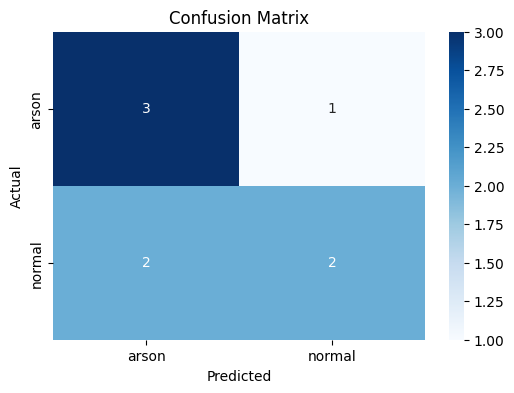

Classification Report:

              precision    recall  f1-score   support

       arson       0.60      0.75      0.67         4
      normal       0.67      0.50      0.57         4

    accuracy                           0.62         8
   macro avg       0.63      0.62      0.62         8
weighted avg       0.63      0.62      0.62         8

AUC Score: 0.8125


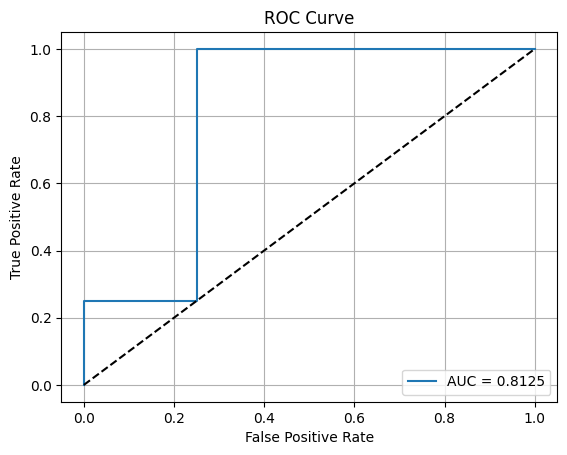

Average Precision Score (mAP): 0.8042


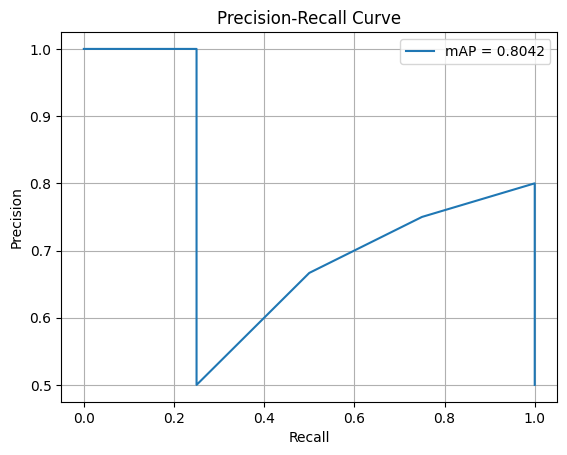

In [ ]:
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# 1. Predict class probabilities and labels
y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test_enc, axis=1)

# 2. Confusion matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# 3. Classification Report (Precision, Recall, F1)
print("Classification Report:\n")
print(classification_report(y_true, y_pred, target_names=le.classes_))

# 4. AUC Score
if y_pred_probs.shape[1] == 2:  # binary classification
    auc_score = roc_auc_score(y_true, y_pred_probs[:, 1])
    print("AUC Score: {:.4f}".format(auc_score))

    # Plot ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_pred_probs[:, 1])
    plt.plot(fpr, tpr, label=f'AUC = {auc_score:.4f}')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve")
    plt.legend()
    plt.grid()
    plt.show()

# 5. Average Precision (mAP for binary)
ap_score = average_precision_score(y_true, y_pred_probs[:, 1])
print("Average Precision Score (mAP): {:.4f}".format(ap_score))

# Precision-Recall curve
precision, recall, _ = precision_recall_curve(y_true, y_pred_probs[:, 1])
plt.plot(recall, precision, label=f'mAP = {ap_score:.4f}')
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve")
plt.legend()
plt.grid()
plt.show()